# Trending-Based Recommendation

## Overview
Trending-Based recommendation is a popularity-based approach with recency weighting. It identifies popular items using interaction counts and average ratings, then boosts recently active items. This serves as both a baseline for evaluation and a cold-start handler for new users without interaction history.

## Notebook Structure
1. **Setup**: Import libraries, configure paths, and set constants
2. **Core Functions**: Data loading, trending score computation with recency weighting, sparse matrix construction
3. **Recommendation**: Generate top-N trending items excluding user's rated items
4. **Evaluation**: Ranking metrics (Recall@K, NDCG@K, MAP@K) on test set
5. **Pipeline**: Train all categories, evaluate, and save artifacts for API integration

## Process Flow
**Training:**
- Load 5-core train split → Compute trending scores: `log(count) * avg_rating * recency_weight`
- `recency_weight = 1.0 + 0.5 * (recent_count / total_count)` where recent = last 90 days
- Build sparse matrix for consistency with other models → Save artifacts (item_stats, R, indexers)

**Evaluation:**
- Load artifacts → For each user, recommend trending items (exclude rated) → Calculate Recall@K, NDCG@K, MAP@K
- Compare with other algorithms as baseline performance

In [13]:
import os, sys, json, pickle, time
import numpy as np, polars as pl
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

module_path = os.path.abspath(os.path.join('..', '../utilities'))
sys.path.append(module_path)

from logger import Logger
from configurations import Configurations
from visualization_helpers import visualize_final_results
from evaluation_metrics import recall_at_k, ndcg_at_k, map_at_k

logger = Logger(process_name="trending", log_file=Configurations.LOG_PATH)

PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
MODELS_DIR = Path(Configurations.MODELS_PATH)
CATEGORY = Configurations.CATEGORIES
EVAL_K_VALUES = [10, 20, 50]

logger.log_info("="*70)
logger.log_info("TRENDING-BASED RECOMMENDATION")
logger.log_info(f"Categories: {CATEGORY} | Sample: {Configurations.DEV_SAMPLE_SIZE}")
logger.log_info("="*70 + "\n")

N_RECS = 10
RECENCY_DAYS = 90

2025-10-26 01:49:16,226 - INFO - ======================================================================
2025-10-26 01:49:16,228 - INFO - TRENDING-BASED RECOMMENDATION
2025-10-26 01:49:16,230 - INFO - Categories: ['Electronics', 'Beauty_and_Personal_Care', 'Sports_and_Outdoors'] | Sample: big
2025-10-26 01:49:16,231 - INFO - ======================================================================



In [14]:
def _candidate_files(category: str, split: str = "train"):
    dev_sample = Configurations.DEV_SAMPLE_SIZE
    safe_cat = category.replace('/', '-')
    
    if dev_sample != 'full':
        for size_name in Configurations.SAMPLE_SIZES.keys():
            if size_name == dev_sample:
                return PROCESSED_DIR / f"{safe_cat}.5core.{split}.{size_name}.parquet"
    return PROCESSED_DIR / f"{safe_cat}.5core.{split}.parquet"

def load_5core_data(category: str, split: str = "train") -> pl.DataFrame:
    p = _candidate_files(category, split)
    df = pl.read_parquet(p, low_memory=False)
    logger.log_info(f"[{split.upper()}] shape={df.shape} | users={df['user_id'].n_unique()} | items={df['parent_asin'].n_unique()}")
    return df

In [15]:
def compute_trending_scores(df_train: pl.DataFrame, recency_days: int = 90):
    logger.log_info("Computing trending scores...")
    
    if 'timestamp' in df_train.columns:
        sample_ts = df_train['timestamp'].head(1).to_list()[0]
        time_unit = 'ms' if sample_ts > 1e12 else 's'
        
        df_train = df_train.with_columns([
            pl.from_epoch(pl.col('timestamp'), time_unit=time_unit).alias('datetime')
        ])
        
        max_date = df_train['datetime'].max()
        max_year = max_date.year if hasattr(max_date, 'year') else 0
        
        if 1970 <= max_year <= 2030:
            cutoff_date = max_date - timedelta(days=recency_days)
            df_train = df_train.with_columns([
                (pl.col('datetime') >= cutoff_date).alias('is_recent')
            ])
            logger.log_info(f"Recent cutoff: {cutoff_date}")
        else:
            df_train = df_train.with_columns([pl.lit(False).alias('is_recent')])
    else:
        df_train = df_train.with_columns([pl.lit(False).alias('is_recent')])
    
    item_stats = df_train.group_by('parent_asin').agg([
        pl.count('rating').alias('n_ratings'),
        pl.mean('rating').alias('avg_rating'),
        pl.sum('is_recent').cast(pl.Int32).alias('n_recent')
    ])
    
    item_stats = item_stats.with_columns([
        (1.0 + 0.5 * (pl.col('n_recent') / pl.col('n_ratings'))).alias('recency_weight'),
        (pl.col('n_ratings').log() * pl.col('avg_rating') * 
         (1.0 + 0.5 * (pl.col('n_recent') / pl.col('n_ratings')))).alias('trending_score')
    ]).sort('trending_score', descending=True)
    
    logger.log_info(f"Computed for {len(item_stats):,} items")
    return item_stats

In [16]:
def build_trending_model(df_train: pl.DataFrame, item_stats: pl.DataFrame):
    items = item_stats['parent_asin'].to_list()
    users = df_train['user_id'].unique().to_list()
    
    user_idx = {u: i for i, u in enumerate(users)}
    item_idx = {a: i for i, a in enumerate(items)}
    
    u = np.array([user_idx[x] for x in df_train['user_id'].to_list()], dtype=np.int32)
    i = np.array([item_idx[x] for x in df_train['parent_asin'].to_list()], dtype=np.int32)
    v = np.array(df_train['rating'].to_list(), dtype=np.float32)
    
    R = csr_matrix((v, (u, i)), shape=(len(users), len(items)), dtype=np.float32)
    logger.log_info(f"Matrix: {R.shape}, nnz={R.nnz:,}")
    
    return R, user_idx, item_idx, np.array(users, dtype=object), np.array(items, dtype=object)

In [17]:
def recommend_trending(user_id: str, n_recs: int, artifacts: dict) -> pl.DataFrame:
    item_stats = artifacts['item_stats']
    R = artifacts['R']
    user_idx = artifacts['user_idx']
    
    rated_items = set()
    if user_id in user_idx:
        u = int(user_idx[user_id])
        rated_items = set(R.getrow(u).indices.tolist())
    
    trending_items = item_stats['parent_asin'].to_list()
    trending_scores = item_stats['trending_score'].to_list()
    
    recommendations = [(item, score) for item, score in zip(trending_items, trending_scores)
                      if item not in rated_items][:n_recs]
    
    if recommendations:
        rec_items, rec_scores = zip(*recommendations)
        return pl.DataFrame({"parent_asin": list(rec_items), "score": list(rec_scores)})
    
    return pl.DataFrame({"parent_asin": [], "score": []})

In [18]:
def save_trending_artifacts(out_dir: Path, item_stats, R, user_rev, item_rev, user_idx, item_idx):
    out_dir.mkdir(parents=True, exist_ok=True)
    item_stats.write_parquet(out_dir / "item_stats.parquet")
    save_npz(out_dir / "R.npz", R)
    with open(out_dir / "user_rev.pkl", "wb") as f: pickle.dump(user_rev, f)
    with open(out_dir / "item_rev.pkl", "wb") as f: pickle.dump(item_rev, f)
    (out_dir / "user_idx.json").write_text(json.dumps({str(k): int(v) for k, v in user_idx.items()}))
    (out_dir / "item_idx.json").write_text(json.dumps({str(k): int(v) for k, v in item_idx.items()}))

def load_trending_artifacts(model_dir: Path):
    item_stats = pl.read_parquet(model_dir / "item_stats.parquet")
    R = load_npz(model_dir / "R.npz")
    with open(model_dir / "user_rev.pkl", "rb") as f: user_rev = pickle.load(f)
    with open(model_dir / "item_rev.pkl", "rb") as f: item_rev = pickle.load(f)
    user_idx = json.loads((model_dir / "user_idx.json").read_text())
    item_idx = json.loads((model_dir / "item_idx.json").read_text())
    return {'item_stats': item_stats, 'R': R, 'user_rev': user_rev, 'item_rev': item_rev,
            'user_idx': user_idx, 'item_idx': item_idx}

In [19]:
def evaluate_trending(category: str, artifacts: dict, k_values: list = None,
                     split: str = "test", sample_users: int = 1000):
    if k_values is None:
        k_values = [10, 20, 50]
    
    df_eval = load_5core_data(category, split=split)
    train_users = list(artifacts['user_idx'].keys())
    df_eval = df_eval.filter(pl.col('user_id').is_in(train_users))
    
    if len(df_eval) == 0:
        return None
    
    eval_users = df_eval['user_id'].unique().to_list()
    if len(eval_users) > sample_users:
        np.random.seed(42)
        eval_users = np.random.choice(eval_users, sample_users, replace=False).tolist()
    
    trending_order = artifacts['item_stats']['parent_asin'].to_list()
    metrics_acc = {f'{m}@{k}': [] for m in ['recall', 'ndcg', 'map'] for k in k_values}
    R, user_idx = artifacts['R'], artifacts['user_idx']
    
    for user_id in eval_users:
        if user_id not in user_idx:
            continue
        
        user_eval = df_eval.filter(pl.col('user_id') == user_id)
        relevant = set(user_eval.filter(pl.col('rating') >= 4)['parent_asin'].to_list())
        
        if not relevant:
            continue
        
        u = int(user_idx[user_id])
        rated = set(R.getrow(u).indices.tolist())
        recommended = [item for item in trending_order if item not in rated]
        
        for k in k_values:
            metrics_acc[f'recall@{k}'].append(recall_at_k(recommended, relevant, k))
            metrics_acc[f'ndcg@{k}'].append(ndcg_at_k(recommended, relevant, k))
            metrics_acc[f'map@{k}'].append(map_at_k(recommended, relevant, k))
    
    results = {'category': category, 'split': split, 'n_users': len(eval_users),
               'rmse': np.nan, 'accuracy': np.nan}
    
    for k in k_values:
        for metric in ['recall', 'ndcg', 'map']:
            key = f'{metric}@{k}'
            results[key] = np.mean(metrics_acc[key]) if metrics_acc[key] else 0.0
    
    logger.log_info(f"[Eval] NDCG@10={results['ndcg@10']:.4f}, Recall@10={results['recall@10']:.4f}")
    return results

In [20]:
def train_trending_model(category: str):
    logger.log_info(f"\n{'='*70}\n{category}\n{'='*70}")
    
    model_dir = MODELS_DIR / "trending" / category
    
    if (model_dir / "R.npz").exists():
        logger.log_info(f"Model exists, skipping\n")
        return
    
    df_train = load_5core_data(category, split="train")
    item_stats = compute_trending_scores(df_train, recency_days=RECENCY_DAYS)
    R, user_idx, item_idx, user_rev, item_rev = build_trending_model(df_train, item_stats)
    save_trending_artifacts(model_dir, item_stats, R, user_rev, item_rev, user_idx, item_idx)
    logger.log_info(f"Saved to {model_dir}\n")

In [21]:
logger.log_info("TRAINING ALL CATEGORIES\n")

for cat in CATEGORY:
    try:
        train_trending_model(cat)
    except Exception as e:
        logger.log_exception(f"{cat}: {e}")

logger.log_info("TRAINING COMPLETE\n")

2025-10-26 01:49:16,601 - INFO - TRAINING ALL CATEGORIES

2025-10-26 01:49:16,603 - INFO - 
Electronics
2025-10-26 01:49:16,625 - INFO - [TRAIN] shape=(85890, 4) | users=35494 | items=82
2025-10-26 01:49:16,626 - INFO - Computing trending scores...
2025-10-26 01:49:16,642 - INFO - Recent cutoff: 2023-02-03 18:32:42.175000
2025-10-26 01:49:16,834 - INFO - Computed for 82 items
2025-10-26 01:49:16,885 - INFO - Matrix: (35494, 82), nnz=85,890
2025-10-26 01:49:16,973 - INFO - Saved to /Users/kevin/Documents/GitHub/Python/VESKL/Personal/NEU/NEU/NEU_7275/Prj/Amazon-Product-Recommendation-System/models/trending/Electronics

2025-10-26 01:49:16,975 - INFO - 
Beauty_and_Personal_Care
2025-10-26 01:49:16,978 - INFO - [TRAIN] shape=(7718, 4) | users=6613 | items=8
2025-10-26 01:49:16,979 - INFO - Computing trending scores...
2025-10-26 01:49:16,980 - INFO - Recent cutoff: 2023-02-23 07:36:59.724000
2025-10-26 01:49:16,981 - INFO - Computed for 8 items
2025-10-26 01:49:16,985 - INFO - Matrix: (661

2025-10-26 01:49:17,025 - INFO - EVALUATION ON TEST SET

2025-10-26 01:49:17,029 - INFO - 
Electronics
2025-10-26 01:49:17,055 - INFO - [TEST] shape=(675, 4) | users=675 | items=76
2025-10-26 01:49:17,224 - INFO - [Eval] NDCG@10=0.0978, Recall@10=0.2144
2025-10-26 01:49:17,225 - INFO - 
Beauty_and_Personal_Care
2025-10-26 01:49:17,231 - INFO - [TEST] shape=(65, 4) | users=65 | items=8
2025-10-26 01:49:17,249 - INFO - [Eval] NDCG@10=0.4723, Recall@10=1.0000
2025-10-26 01:49:17,250 - INFO - 
Sports_and_Outdoors
2025-10-26 01:49:17,254 - INFO - [TEST] shape=(11, 4) | users=11 | items=3
2025-10-26 01:49:17,258 - INFO - [Eval] NDCG@10=0.7524, Recall@10=1.0000


category,split,n_users,rmse,accuracy,recall@10,ndcg@10,map@10,recall@20,ndcg@20,map@20,recall@50,ndcg@50,map@50
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Electronics""","""test""",675,NaN,NaN,0.214414,0.097759,0.063298,0.340541,0.129061,0.071606,0.612613,0.182668,0.080072
"""Beauty_and_Personal_Care""","""test""",65,NaN,NaN,1.0,0.472346,0.30824,1.0,0.472346,0.30824,1.0,0.472346,0.30824
"""Sports_and_Outdoors""","""test""",11,NaN,NaN,1.0,0.752372,0.666667,1.0,0.752372,0.666667,1.0,0.752372,0.666667


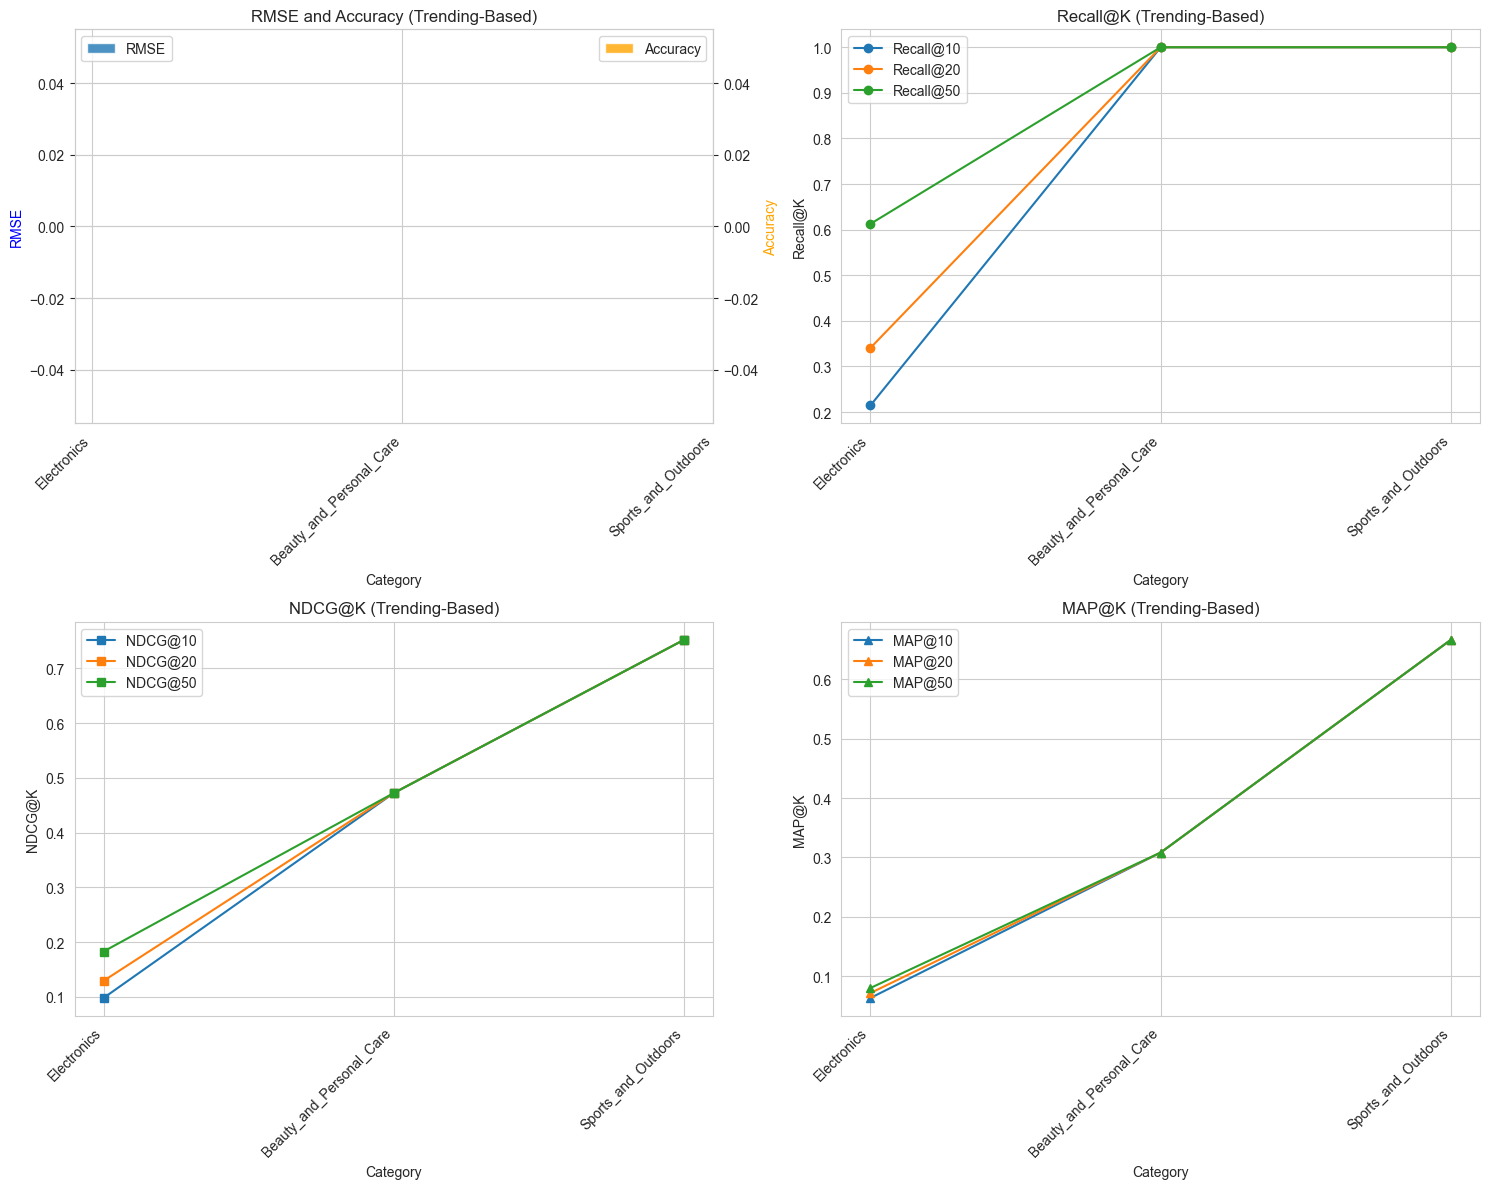

2025-10-26 01:49:18,205 - INFO - 
COMPLETE


In [22]:
logger.log_info("EVALUATION ON TEST SET\n")

test_results = []

for cat in CATEGORY:
    logger.log_info(f"\n{cat}")
    try:
        model_dir = MODELS_DIR / "trending" / cat
        if not model_dir.exists():
            continue
        
        artifacts = load_trending_artifacts(model_dir)
        results = evaluate_trending(cat, artifacts, k_values=EVAL_K_VALUES, split="test",
                                   sample_users=Configurations.get_eval_samples_final())
        
        if results:
            test_results.append(results)
    except Exception as e:
        logger.log_exception(f"{cat}: {e}")

if test_results:
    df_results = pl.DataFrame(test_results)
    display(df_results)
    df_results.write_csv(MODELS_DIR / 'trending' / 'final_test_results.csv')
    visualize_final_results(test_results, save_dir=MODELS_DIR / 'trending',
                           algo_name='Trending-Based', k_values=EVAL_K_VALUES)

logger.log_info("\nCOMPLETE")

In [23]:
def recommend_trending_ui(user_id: str, n_recs: int = 5, models_dir: Path = None, category: str = None):
    cat = category or CATEGORY[0]
    model_dir = models_dir if models_dir else (MODELS_DIR / "trending" / cat)
    artifacts = load_trending_artifacts(model_dir)
    return recommend_trending(user_id, n_recs, artifacts)

def test_all_categories():
    for cat in CATEGORY:
        try:
            model_dir = MODELS_DIR / "trending" / cat
            if not model_dir.exists():
                continue
            artifacts = load_trending_artifacts(model_dir)
            user_rev = artifacts['user_rev']
            if len(user_rev) > 0:
                recs = recommend_trending_ui(user_rev[0], n_recs=N_RECS, category=cat)
                display(recs)
        except Exception as e:
            logger.log_exception(f"{cat}: {e}")

In [24]:
test_all_categories()

parent_asin,score
str,f64
"""B011BRUOMO""",37.155006
"""B0BGNG1294""",36.406678
"""B07P9V8GSH""",35.316427
"""B01K8B8YA8""",35.130491
"""B008J0Z9TA""",34.558492
"""B075X8471B""",34.063026
"""B07GZFM1ZM""",33.899784
"""B071R715MZ""",33.784275
"""B08KG14KCT""",33.697259


parent_asin,score
str,f64
"""B0BVW6XYNZ""",31.208725
"""B07YT2VKTG""",30.709947
"""B0B6QVGZ4X""",29.415816
"""B073WVCH57""",29.000636
"""B0BVGHXZJ1""",28.889719
"""B0C4K2HYLZ""",28.41928
"""B09GN3GC8G""",28.157287
"""B09GN3GC8C""",26.658579


parent_asin,score
str,f64
"""B0BX5QFWQN""",33.027719
"""B08HWP19XK""",32.241697
"""B0BBFB48YQ""",31.640876
